In [2]:
import lightning as L
import torch

from data.datamodule import BlenderDataModule
from model.lightningmodule import MobileR2LLighningModule

In [3]:
data_path = "../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego"
datamodule = BlenderDataModule(data_path, 4, 16, rand=True)
model = MobileR2LLighningModule(5e-4, 16*3, 10, 256, 16, 3)
trainer = L.Trainer(
    enable_checkpointing=False,
    max_steps=10_000
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [4]:
trainer.fit(
    model,
    datamodule,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                 | Params
----------------------------------------------------
0 | model      | MobileR2L            | 3.2 M 
1 | train_psnr | PeakSignalNoiseRatio | 0     
2 | val_psnr   | PeakSignalNoiseRatio | 0     
3 | test_psnr  | PeakSignalNoiseRatio | 0     
----------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.629    Total estimated model params size (MB)


searching for images...
loading poses...
done
[PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00000.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00001.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00002.npy')] [PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/0.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/1.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/2.png')]
Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]                           

/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f3641071a50>>
Traceback (most recent call last):
  File "/home/joze/envs/sandbox-venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 

In [4]:
model = MobileR2LLighningModule.load_from_checkpoint("../../checkpoints/epoch=124-step=100000.ckpt")

searching for images...
loading poses...
done
[PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00000.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00001.npy'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/poses/c2w_00002.npy')] [PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/0.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/1.png'), PosixPath('../../../MobileR2L/model/teacher/ngp_pl/Pseudo/lego/vis/2.png')]
tensor(8.9367, device='cuda:0')


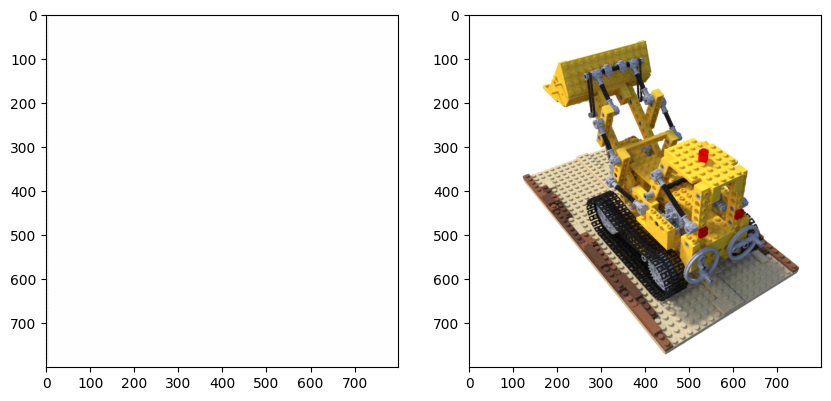

In [6]:
from matplotlib import pyplot as plt
import torch

datamodule.setup("test")
rays, img = datamodule.test[1]

with torch.no_grad():
    pred_img = model.model(torch.zeros_like(rays).unsqueeze(0).cuda()).cpu()

print(model.train_psnr(pred_img, img))

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(pred_img.squeeze(0).permute(1, 2, 0))
ax[1].imshow(img.permute(1, 2, 0))

In [7]:
pred_img

tensor([[[[0.7067, 0.9920, 0.9980,  ..., 0.8621, 0.8061, 0.3492],
          [0.9310, 0.9933, 0.9975,  ..., 0.8419, 0.8836, 0.5602],
          [0.9899, 0.9984, 0.9991,  ..., 0.9104, 0.7952, 0.5217],
          ...,
          [0.8751, 0.9840, 0.9931,  ..., 0.9993, 0.9992, 0.9556],
          [0.9734, 0.9974, 0.9993,  ..., 0.9995, 0.9964, 0.9385],
          [0.7847, 0.9743, 0.9954,  ..., 0.9503, 0.9530, 0.4517]],

         [[0.6233, 0.9842, 0.9957,  ..., 0.8572, 0.7840, 0.3553],
          [0.9206, 0.9914, 0.9963,  ..., 0.8793, 0.8852, 0.6081],
          [0.9790, 0.9957, 0.9986,  ..., 0.9123, 0.8021, 0.4997],
          ...,
          [0.8608, 0.9862, 0.9939,  ..., 0.9986, 0.9985, 0.9492],
          [0.9543, 0.9951, 0.9991,  ..., 0.9982, 0.9942, 0.9078],
          [0.7699, 0.9742, 0.9946,  ..., 0.9416, 0.9477, 0.4598]],

         [[0.5211, 0.9683, 0.9923,  ..., 0.8397, 0.7614, 0.3732],
          [0.9389, 0.9904, 0.9972,  ..., 0.8899, 0.9424, 0.6582],
          [0.9508, 0.9931, 0.9979,  ..., 0

In [30]:
from math import sin, cos, radians
from data.utils import get_rays
import cv2
from tqdm import tqdm
from torch.nn import functional as F

H, W, focal, near, far = 100, 100, 138, 2, 6
num_samples, emb_dim = 16, 10
device = "cuda"

tr_r = lambda r : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,r],
    [0,0,0,1.],
])

rot_phi = lambda phi: torch.tensor([
    [1,0,0,0],
    [0,cos(phi),-sin(phi),0],
    [0,sin(phi), cos(phi),0],
    [0,0,0,1.],
])

rot_theta = lambda th : torch.tensor([
    [cos(th),0,-sin(th),0],
    [0,1,0,0],
    [sin(th),0, cos(th),0],
    [0,0,0,1.],
])

def get_pose_spherical(r, phi, theta):
    perm = torch.tensor([[-1.,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    return perm @ rot_theta(radians(theta)) @ rot_phi(radians(phi)) @ tr_r(r)

writer = cv2.VideoWriter(
    "output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (100,100))

for th in tqdm(torch.linspace(0, 360, 120)):
    pose = get_pose_spherical(4,-30, th)
    rays = get_rays(H, W, focal, pose, near, far, num_samples, False).to(device)
    with torch.no_grad():
        pred_img = model.model(rays.unsqueeze(0)).squeeze(0).permute(1, 2, 0)
    plt.imshow(pred_img.cpu())
    cv2img = cv2.cvtColor((pred_img * 255).cpu().to(torch.uint8).numpy(), cv2.COLOR_RGB2BGR)
    writer.write(cv2img)

writer.release()

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [31]:
pose

tensor([[-1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.5000,  0.8660,  3.4641],
        [ 0.0000,  0.8660,  0.5000,  2.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

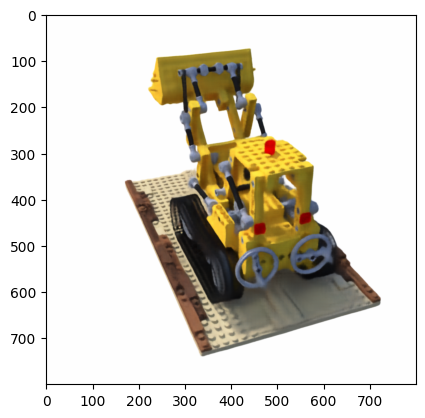

In [7]:
plt.imshow(pred_img.cpu())

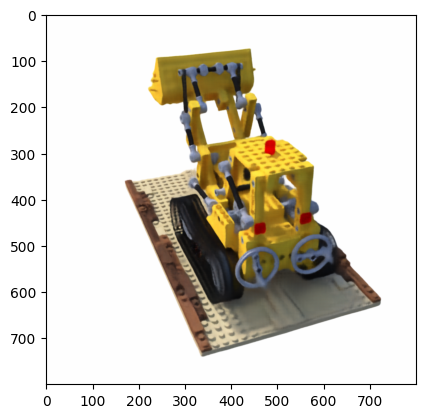

In [8]:
from torch import nn

class NeLFInferencer(nn.Module):

    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, pose):
        rays = get_rays(100, 100, 138, pose, 2, 6, 16, False)
        img = self.model(rays.unsqueeze(0)).squeeze(0).permute(1, 2, 0)
        return img
    
infr = NeLFInferencer(model.model.eval().cpu())
with torch.no_grad():
    plt.imshow(infr(pose))

In [11]:
import onnxruntime
import numpy as np

out_path = "model.onnx"

torch_model = model.model.eval().cpu()
dummy_input = torch.zeros_like(rays).unsqueeze(0)
#torch_model = infr
#dummy_input = torch.eye(4)

#save to onnx
torch.onnx.export(torch_model,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  out_path,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=16,          # the ONNX version to export the model to
                  input_names=["in"],
                  output_names=["out"], 
                  )

torch_out=torch_model(dummy_input)
ort_session = onnxruntime.InferenceSession(out_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


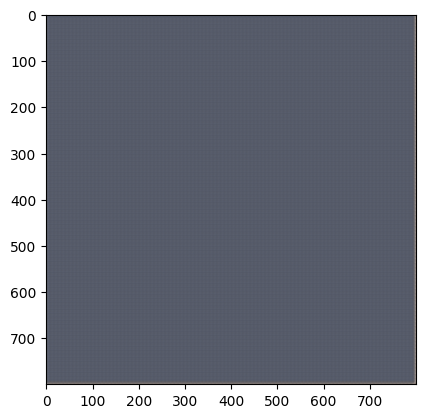

In [25]:
plt.imshow(torch_out.detach().squeeze().permute(1, 2, 0))